In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold, cross_val_score
from sklearn.linear_model import LogisticRegression
import seaborn as sns

In [31]:
# Load data
dir = '/mnt/data/2020_Projects/2021_HDP/03_Data/FBCcalc_normPathways/'
dir_clinical = '/mnt/data/2020_Projects/2021_HDP/03_Data/FBCcalc_simbio_fastfield_20subj/'

df_model_HDP = pd.read_csv(dir + 'df_model_HDP.csv')
df_model_CST = pd.read_csv(dir + 'df_model_CST.csv')

clinical_HDP_all = pd.read_csv(dir_clinical + 'clinical_mA_effect.csv')
clinical_CST_all = pd.read_csv(dir_clinical + 'clinical_mA_side_effect_capsular.csv')

In [32]:
# clinical_mA_side_effect_capsular.csv contains nan in 'mA_capsular' for those contacts that result in non-capsular side effects
clinical_CST_all = clinical_CST_all.dropna()
clinical_CST_all.drop('mA', axis=1, inplace=True)

In [33]:
# keep only tested contacts, where mA ~= 0
clinical_HDP = clinical_HDP_all[(clinical_HDP_all['mA'] > 0) & (clinical_HDP_all['mA'] < 8)]
clinical_CST = clinical_CST_all[(clinical_CST_all['mA_capsular'] > 0) & (clinical_CST_all['mA_capsular'] < 8)]

In [34]:
# select best contact from df_model
# model_pred == 1
df_model1_HDP = df_model_HDP[(df_model_HDP['model_pred'] == 1)]
df_model1_CST = df_model_CST[(df_model_CST['model_pred'] == 1)]

# contact with smallest mA
best_contact_HDP = df_model1_HDP.groupby(['LeadID', 'ContactID'], as_index=False).mA.min()
best_contact_HDP.rename(columns={'mA': 'mA_model'}, inplace=True)  #rename column

best_contact_CST = df_model1_CST.groupby(['LeadID', 'ContactID'], as_index=False).mA.min()
best_contact_CST.rename(columns={'mA': 'mA_model'}, inplace=True)

# filter contacts in best_contact to keep only those present in clinical_mA
df_clinical_model_CST = pd.merge(clinical_CST, best_contact_CST, how="left", on=['LeadID', 'ContactID'])
df_clinical_model_HDP = pd.merge(clinical_HDP, best_contact_HDP, how="left", on=['LeadID', 'ContactID'])

In [21]:
# CST --> in the patient-specific models there are some contacts for which there are side effects in clinical but the model predicts no side effects -> it's possible that these are non capsular side effects. For now, remove the contacts for which df_clinical_model['mA_model'] == nan
#df_clinical_model_CST = df_clinical_model_CST.dropna()

# But in the norm tract models, in the HDP there is one contact that the model doesn't predict effect (idx 47) and for the CST in 218/276 contacts the model is not predicting side effect

# If dropping nan, median error for CST is 3.5 mA:
#df_clinical_model_CST = df_clinical_model_CST.dropna()
#df_clinical_model_HDP = df_clinical_model_HDP.dropna()

# If replacing nan for 8.5, median error 4 mA
df_clinical_model_CST['mA_model'] = df_clinical_model_CST.mA_model.fillna(8.5)
df_clinical_model_HDP['mA_model'] = df_clinical_model_HDP.mA_model.fillna(8.5)

# I think it makes sense to compare only the thresholds where the model predicted effect or side effect and report that the model is failing at predicting the side effect in 218 out of 276 cases

## HDP

In [35]:
# error diff
df_clinical_model_HDP['mA_diff'] = df_clinical_model_HDP['mA_model'] - df_clinical_model_HDP['mA']
df_clinical_model_HDP['mA_diff_abs'] = abs(df_clinical_model_HDP['mA_model'] - df_clinical_model_HDP['mA'])

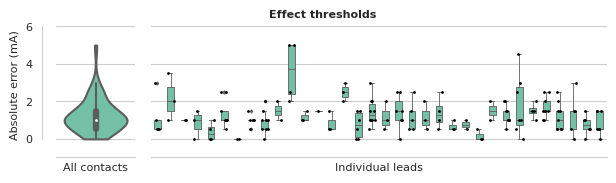

In [36]:
yticks = np.arange(0,7,2)

sns.set_style("whitegrid")
plt.rc('font', size=8)

fig = plt.figure()
fig.set_figheight(3.35)
fig.set_figwidth(7.1)
fig.suptitle('Effect thresholds', fontweight='heavy', fontsize=8, y=0.93)

ax1 = plt.subplot2grid(shape=(2, 6), loc=(0, 0), colspan=1)
ax2 = plt.subplot2grid(shape=(2, 6), loc=(0, 1), colspan=5)

sns.set_style("whitegrid")
plt.rc('font', size=8)

sns.violinplot(data=df_clinical_model_HDP.mA_diff_abs, color='mediumaquamarine', cut=0, scale='count', ax=ax1)

ax1.set_xlabel('All contacts')
ax1.set_ylabel('Absolute error (mA)')
ax1.set_yticks(yticks)
ax1.set_xticks([])

sns.boxplot(x="LeadID", y="mA_diff_abs", data=df_clinical_model_HDP, color='mediumaquamarine', width=0.5, linewidth=0.6, fliersize=1.5, ax=ax2)
sns.stripplot(x="LeadID", y="mA_diff_abs", data=df_clinical_model_HDP, color="black", jitter=0.25, size=2, ax=ax2)

ax2.set_xlabel('Individual leads')
ax2.set_ylabel('')
ax2.set_xticks([])
ax2.set_yticks(yticks, labels='')

sns.despine(offset=10, trim=True, ax=ax1)
sns.despine(offset=10, left=True, ax=ax2)

plt.savefig(dir +'th_HDP.png', dpi=300, bbox_inches='tight')

In [37]:
df_clinical_model_HDP.mA_diff_abs.median()

1.0

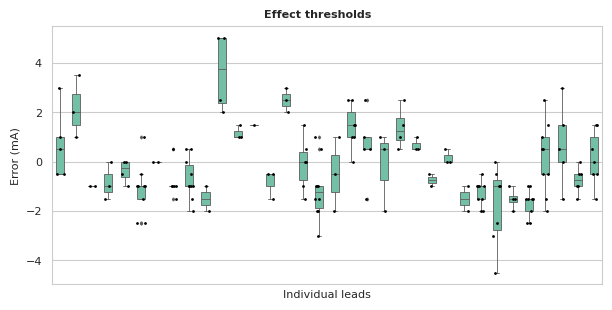

In [38]:
#yticks = np.arange(-5,6,2)

sns.set_style("whitegrid")
plt.rc('font', size=8)

fig = plt.figure()
fig.set_figheight(3.35)
fig.set_figwidth(7.1)
fig.suptitle('Effect thresholds', fontweight='heavy', fontsize=8, y=0.93)

#ax1 = plt.subplot2grid(shape=(2, 6), loc=(0, 0), colspan=1)
ax2 = plt.subplot2grid(shape=(1, 6), loc=(0, 0), colspan=6)


sns.boxplot(x="LeadID", y="mA_diff", data=df_clinical_model_HDP, color='mediumaquamarine', width=0.5, linewidth=0.6, fliersize=1.5, ax=ax2)
sns.stripplot(x="LeadID", y="mA_diff", data=df_clinical_model_HDP, color="black", jitter=0.25, size=2, ax=ax2)

ax2.set_xlabel('Individual leads')
ax2.set_ylabel('Error (mA)')
ax2.set_xticks([])
#ax2.set_yticks(yticks)

#sns.despine(offset=10, trim=True, ax=ax1)
#sns.despine(offset=10, left=True, ax=ax2)

plt.savefig(dir + 'th_HDP_signed.png', dpi=300, bbox_inches='tight')

## CST

In [39]:
# error diff
df_clinical_model_CST.rename(columns={'mA_capsular': 'mA'}, inplace=True)
df_clinical_model_CST['mA_diff'] = df_clinical_model_CST['mA_model'] - df_clinical_model_CST['mA']
df_clinical_model_CST['mA_diff_abs'] = abs(df_clinical_model_CST['mA_model'] - df_clinical_model_CST['mA'])

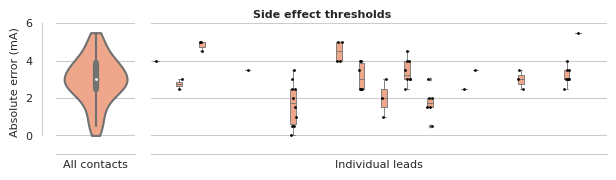

In [40]:
yticks = np.arange(0,7,2)

sns.set_style("whitegrid")
plt.rc('font', size=8)

fig = plt.figure()
fig.set_figheight(3.35)
fig.set_figwidth(7.1)
fig.suptitle('Side effect thresholds', fontweight='heavy', fontsize=8, y=0.92,)

ax1 = plt.subplot2grid(shape=(2, 6), loc=(0, 0), colspan=1)
ax2 = plt.subplot2grid(shape=(2, 6), loc=(0, 1), colspan=5)

sns.set_style("whitegrid")
plt.rc('font', size=8)

sns.violinplot(data=df_clinical_model_CST.mA_diff_abs, color='lightsalmon', cut=0, scale='count', ax=ax1)

ax1.set_xlabel('All contacts')
ax1.set_ylabel('Absolute error (mA)')
ax1.set_yticks(yticks)
ax1.set_xticks([])

sns.boxplot(x="LeadID", y="mA_diff_abs", data=df_clinical_model_CST, color='lightsalmon', width=0.5, linewidth=0.6, fliersize=1.5, ax=ax2)
sns.stripplot(x="LeadID", y="mA_diff_abs", data=df_clinical_model_CST, color="black", jitter=0.25, size=2, ax=ax2)

ax2.set_xlabel('Individual leads')
ax2.set_ylabel('')
ax2.set_xticks([])
ax2.set_yticks(yticks, labels='')

sns.despine(offset=10, trim=True, ax=ax1)
sns.despine(offset=10, left=True, ax=ax2)

plt.savefig(dir + 'th_CST_withNaN.png', dpi=300, bbox_inches='tight')

In [41]:
df_clinical_model_CST.mA_diff_abs.median()

3.0

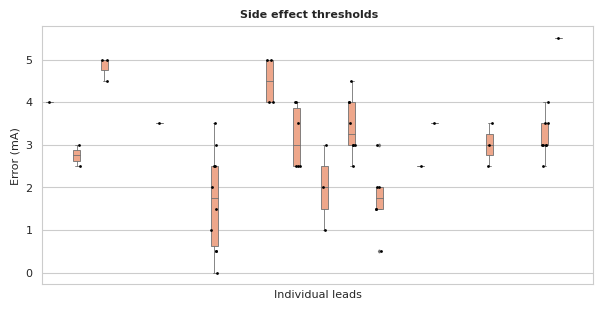

In [42]:
#yticks = np.arange(-5,6,2)

sns.set_style("whitegrid")
plt.rc('font', size=8)

fig = plt.figure()
fig.set_figheight(3.35)
fig.set_figwidth(7.1)
fig.suptitle('Side effect thresholds', fontweight='heavy', fontsize=8, y=0.93)

#ax1 = plt.subplot2grid(shape=(2, 6), loc=(0, 0), colspan=1)
ax2 = plt.subplot2grid(shape=(1, 6), loc=(0, 0), colspan=6)


sns.boxplot(x="LeadID", y="mA_diff", data=df_clinical_model_CST, color='lightsalmon', width=0.5, linewidth=0.6, fliersize=1.5, ax=ax2)
sns.stripplot(x="LeadID", y="mA_diff", data=df_clinical_model_CST, color="black", jitter=0.25, size=2, ax=ax2)

ax2.set_xlabel('Individual leads')
ax2.set_ylabel('Error (mA)')
ax2.set_xticks([])
#ax2.set_yticks(yticks)

#sns.despine(offset=10, trim=True, ax=ax1)
#sns.despine(offset=10, left=True, ax=ax2)

plt.savefig(dir + 'th_CST_signed_withNaN.png', dpi=300, bbox_inches='tight')

In [43]:
# Save data for Wilcoxon tests
#df_clinical_model_HDP.to_csv( dir + 'df_clinical_model_HDP_withoutNaN.csv', index=False)
#df_clinical_model_CST.to_csv( dir + 'df_clinical_model_CST_withoutNaN.csv', index=False)

# here NaN values are replaced for 8.5
#df_clinical_model_HDP.to_csv( dir + 'df_clinical_model_HDP_with85.csv', index=False)
#df_clinical_model_CST.to_csv( dir + 'df_clinical_model_CST_with85.csv', index=False)

#data with NaN
df_clinical_model_HDP.to_csv( dir + 'df_clinical_model_HDP_withNaN.csv', index=False)
df_clinical_model_CST.to_csv( dir + 'df_clinical_model_CST_withNaN.csv', index=False)

#### Repeated measures correlation

In [23]:
# Pearson
import scipy.stats as stats
r = stats.pearsonr(df_clinical_model_HDP['mA'], df_clinical_model_HDP['mA_model'])
print(r) # (pearson, p)

PearsonRResult(statistic=0.2382193095224217, pvalue=0.002061667813179588)


In [19]:
# Pearson
import scipy.stats as stats
r = stats.pearsonr(df_clinical_model_CST['mA'], df_clinical_model_CST['mA_model'])
print(r) # (pearson, p)

PearsonRResult(statistic=0.3085981778699916, pvalue=1.678701269305482e-07)


In [20]:
# edited plot function to modify scatter plot
def plot_rm_corr_ed(data=None, x=None, y=None, subject=None, legend=False,
                 kwargs_facetgrid=dict(height=4, aspect=1), color_l=None, color_p=None):

    # Check that stasmodels is installed
    from pingouin.utils import _is_statsmodels_installed
    _is_statsmodels_installed(raise_error=True)
    from statsmodels.formula.api import ols

    # Safety check (duplicated from pingouin.rm_corr)
    assert isinstance(data, pd.DataFrame), 'Data must be a DataFrame'
    assert x in data.columns, 'The %s column is not in data.' % x
    assert y in data.columns, 'The %s column is not in data.' % y
    assert data[x].dtype.kind in 'bfiu', '%s must be numeric.' % x
    assert data[y].dtype.kind in 'bfiu', '%s must be numeric.' % y
    assert subject in data.columns, 'The %s column is not in data.' % subject
    if data[subject].nunique() < 3:
        raise ValueError('rm_corr requires at least 3 unique subjects.')

    # Remove missing values
    data = data[[x, y, subject]].dropna(axis=0)

    # Calculate rm_corr
    # rmc = pg.rm_corr(data=data, x=x, y=y, subject=subject)

    # Fit ANCOVA model
    # https://patsy.readthedocs.io/en/latest/builtins-reference.html
    # C marks the data as categorical
    # Q allows to quote variable that do not meet Python variable name rule
    # e.g. if variable is "weight.in.kg" or "2A"
    formula = "Q('%s') ~ C(Q('%s')) + Q('%s')" % (y, subject, x)
    model = ols(formula, data=data).fit()

    # Fitted values
    data['pred'] = model.fittedvalues

    # Define color palette
    #if 'palette' not in kwargs_facetgrid:
     #   kwargs_facetgrid['palette'] = sns.hls_palette(data[subject].nunique())

    # Start plot
    g = sns.FacetGrid(data, hue=subject, **kwargs_facetgrid)
    g = g.map(sns.regplot, x, "pred", scatter=False, ci=None, truncate=True, color=color_l)
    #g = g.map(sns.scatterplot, x, y, alpha=0.8, color=color_p) #with scatterplot jitter doesn't seem to work, use regplot instead
    g = g.map(sns.regplot, x, y, fit_reg = False, color=color_p, scatter_kws = {'alpha':0.5, 's':20}, x_jitter=0.1)

    if legend:
        g.add_legend()

    return g

               r  dof      pval         CI95%     power
rm_corr  0.07411  129  0.400207  [-0.1, 0.24]  0.134351


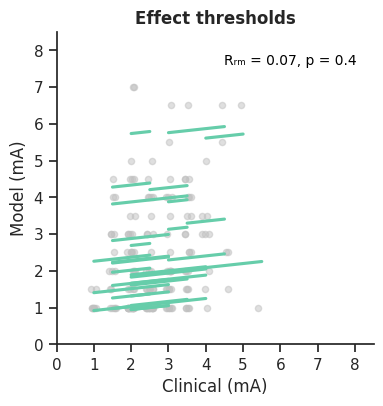

In [24]:
# HDP
import pingouin as pg
rm_HDP = pg.rm_corr(data=df_clinical_model_HDP, x='mA', y='mA_model', subject='LeadID')
print(rm_HDP)

custom_params = {"axes.spines.right": False, "axes.spines.top": False}
sns.set_theme(style="ticks", rc=custom_params)

rm = plot_rm_corr_ed(data=df_clinical_model_HDP, x='mA', y='mA_model', subject='LeadID', color_l = 'mediumaquamarine',
color_p = 'silver')

plt.xlim([0, 8.5])
plt.ylim([0, 8.5])
xticks = np.arange(0,9,1)
plt.xticks(xticks)

plt.xlabel('Clinical (mA)')
plt.ylabel('Model (mA)')
plt.title('Effect thresholds', {'weight':'heavy'})

plt.text(4.5,7.6, u'R\u1D63\u2098 = ' + str(round(rm_HDP.loc['rm_corr']['r'],2)) + ', p = ' + str(round(rm_HDP.loc['rm_corr']['pval'],2)), {'color':'black', 'size':10})

plt.savefig(dir + 'rm_corr_HDP.png', dpi=300, bbox_inches='tight')

                r  dof      pval        CI95%   power
rm_corr  0.289761  235  0.000006  [0.17, 0.4]  0.9955


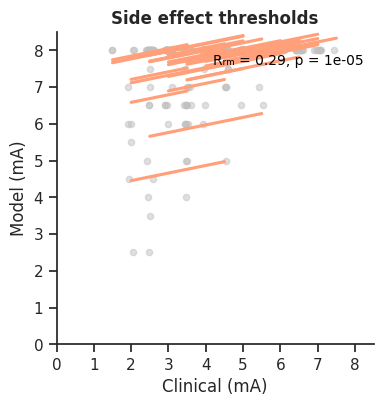

In [25]:
# CST
import pingouin as pg
rm_CST = pg.rm_corr(data=df_clinical_model_CST, x='mA', y='mA_model', subject='LeadID')
print(rm_CST)

rm = plot_rm_corr_ed(data=df_clinical_model_CST, x='mA', y='mA_model', subject='LeadID', color_l = 'lightsalmon', color_p = 'silver')

plt.xlim([0, 8.5])
plt.ylim([0, 8.5])
plt.ylim([0, 8.5])
xticks = np.arange(0,9,1)
plt.xticks(xticks)

plt.xlabel('Clinical (mA)')
plt.ylabel('Model (mA)')
plt.title('Side effect thresholds', {'weight':'heavy'})

plt.text(4.2,7.6, u'R\u1D63\u2098 = ' + str(round(rm_CST.loc['rm_corr']['r'],2)) + ', p = ' + str(round(rm_CST.loc['rm_corr']['pval'],5)), {'color':'black', 'size':10})

plt.savefig(dir + 'rm_corr_CST.png', dpi=300, bbox_inches='tight')

### Linear regression

Text(0.5, 1.0, 'HDP')

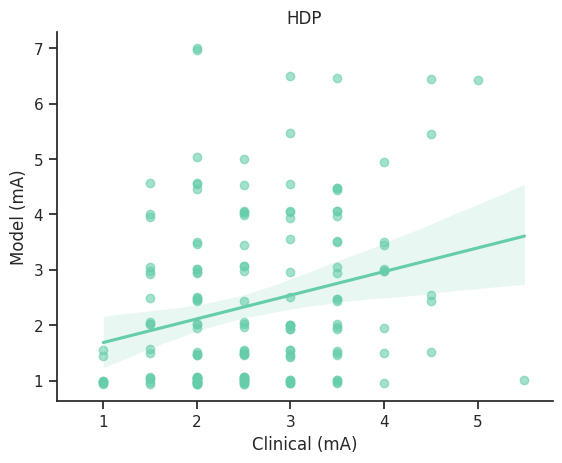

In [26]:
import seaborn as sns

ax = sns.regplot(data=df_clinical_model_HDP, x='mA', y='mA_model', y_jitter=.07, scatter_kws={'alpha':0.6}, color='mediumaquamarine' )

plt.xlim([0.5, 5.8])
#plt.ylim([0, 8.5])

plt.xlabel('Clinical (mA)')
plt.ylabel('Model (mA)')
plt.title('HDP')
#plt.savefig('/mnt/data/2020_Projects/2021_HDP/03_Data/Plots/regplot_HDP.png', dpi=300, bbox_inches='tight')

Text(0.5, 1.0, 'CST')

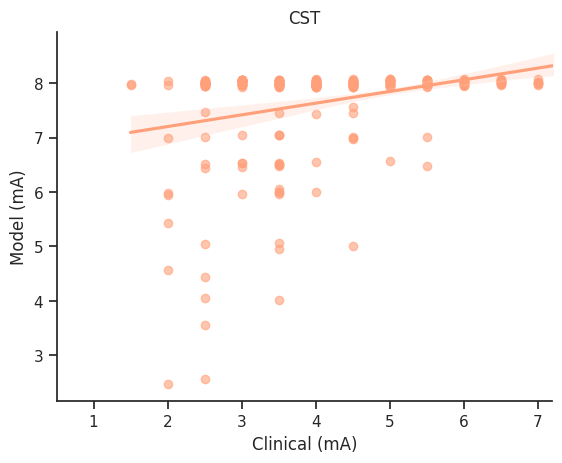

In [27]:
import seaborn as sns

ax = sns.regplot(data=df_clinical_model_CST, x='mA', y='mA_model', y_jitter=.07, scatter_kws={'alpha':0.6}, color='lightsalmon')

plt.xlim([0.5, 7.2])
#plt.ylim([0, 8.5])

plt.xlabel('Clinical (mA)')
plt.ylabel('Model (mA)')
plt.title('CST')

#plt.savefig('/mnt/data/2020_Projects/2021_HDP/03_Data/Plots/regplot_CST.png', dpi=300, bbox_inches='tight')